In [1]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.applications.vgg16 import (
    VGG16, preprocess_input, decode_predictions)
from tensorflow.keras.preprocessing import image
from keras.layers.core import Lambda
from tensorflow.keras.models import Sequential
from tensorflow.python.framework import ops
import keras.backend as K
import tensorflow as tf
import numpy as np
import keras
import sys
import cv2

import keras
import tensorflow as tf

from keras.datasets import mnist

from keras.datasets import cifar10


num_classes = 10
epochs = 20
batch_size=256
img_rows, img_cols = 32, 32
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

/home/jake/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jake/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jake/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jake/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: P

In [2]:
tf.test.is_gpu_available()

True

In [13]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [15]:
label_list = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

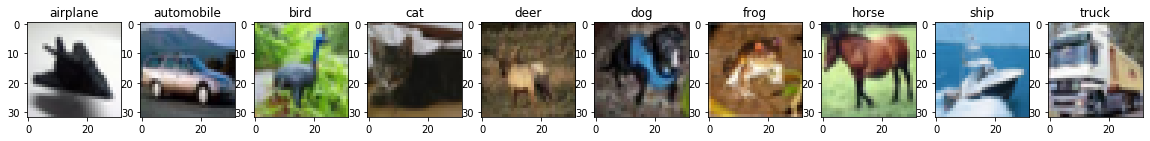

In [16]:
plt.figure(figsize=(20, 20))
for i in range(10):
    plt.subplot(1,10,i+1)
    coord = np.where(y_train.flatten() == i)[0][0]
    plt.imshow(x_train[coord])
    plt.title(label_list[y_train[coord][0]])

plt.show()

In [17]:
os.environ["CUDA_VISIBLE_DEVICES"]="1";  
from keras.backend.tensorflow_backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
tf.compat.v1.Session(config=config)

In [ ]:
model = tf.keras.models.load_model('../models/cifar10_gradcam.h5')
#model = keras.models.load_model('./cifar10.h5')


In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                10250     
Total params: 15,250,250
Trainable params: 15,250,250
Non-trainable params: 0
_________________________________________________________________


In [19]:
idx = 5
#print(model.predict_on_batch(x_test[idx][np.newaxis,...,np.newaxis]/255))
#print(y_test[idx])

## Saliency

![Screenshot from 2019-11-15 12-56-30](https://user-images.githubusercontent.com/33189954/68916005-95a87700-07a7-11ea-9800-00fcedab36d1.png)

In [23]:
def get_saliency(idx, model):
    y_c = model.output[0, idx]
    grads = keras.backend.gradients(y_c, model.input)[0]
    saliency = keras.backend.function([model.input], [grads])
    return saliency([x_test[idx][np.newaxis,...,np.newaxis]/255])

grads_orig = get_saliency(idx, model)
s_map = np.abs(grads_orig[0][0].mean(axis=-1))

plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(x_test[idx])
plt.title(label_list[y_test[idx]])
plt.subplot(122)
plt.imshow(s_map, 'gray')
plt.title('Saliency Map')
plt.show()

InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument:  input must be 4-dimensional[1,32,32,3,1]
	 [[node vgg16_1/block1_conv1/Conv2D (defined at /home/jake/venv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3009) ]]
	 [[dropout_1_1/cond/then/_0/dropout/mul/_24]]
  (1) Invalid argument:  input must be 4-dimensional[1,32,32,3,1]
	 [[node vgg16_1/block1_conv1/Conv2D (defined at /home/jake/venv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3009) ]]
0 successful operations.
0 derived errors ignored. [Op:__inference_keras_scratch_graph_6567]

Function call stack:
keras_scratch_graph -> keras_scratch_graph


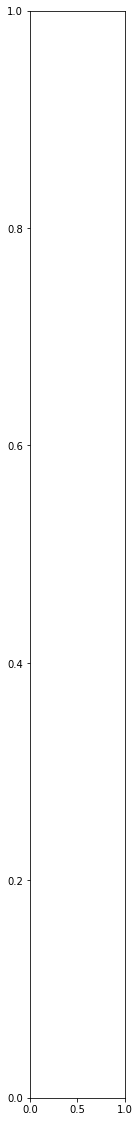

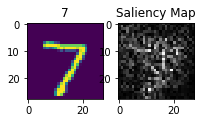

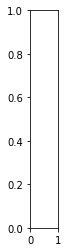

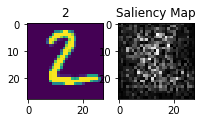

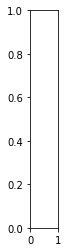

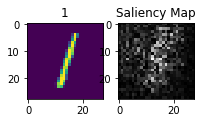

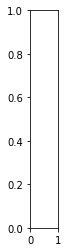

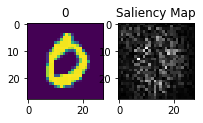

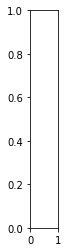

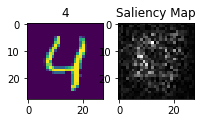

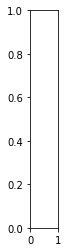

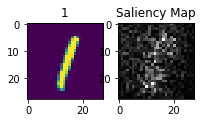

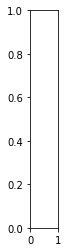

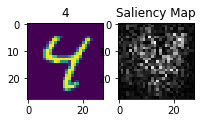

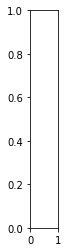

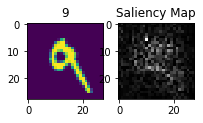

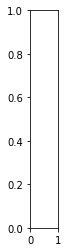

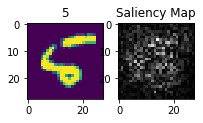

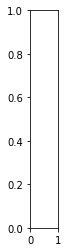

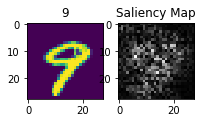

In [9]:
plt.figure(figsize=(20, 20))
for idx in range(10):
    plt.subplot(1,10,idx+1)
    coord = np.where(y_train.flatten() == idx)[0][0]
    #plt.imshow(x_train[coord])
    grads_orig=get_saliency(idx, model)
    s_map = np.abs(grads_orig[0][0].mean(axis=-1))
    
    plt.figure(figsize=(3,3))
    plt.subplot(121)
    plt.imshow(x_test[idx])
    plt.title(label_list[y_test[idx]])
    plt.subplot(122)
    plt.imshow(s_map, 'gray')
    plt.title('Saliency Map')
    plt.show()

#plt.show()

# SmoothGrad
![Screenshot from 2019-11-15 12-59-28](https://user-images.githubusercontent.com/33189954/68916071-d0121400-07a7-11ea-9c3b-379e40782747.png)

In [14]:
def get_smoothgrad(idx,model,n = 10, sigma = 1):
    y_c = model.output[0,idx]
    grad = keras.backend.gradients(y_c,model.input)[0]
    saliency = keras.backend.function([model.input],[grad])
    img_input = x_test[idx][np.newaxis,...,np.newaxis]/255
    result = np.zeros_like(img_input)
    for i in range(n):
        result += saliency([img_input + np.random.normal(scale=sigma,size=img_input.shape)])[0]
        return result / n

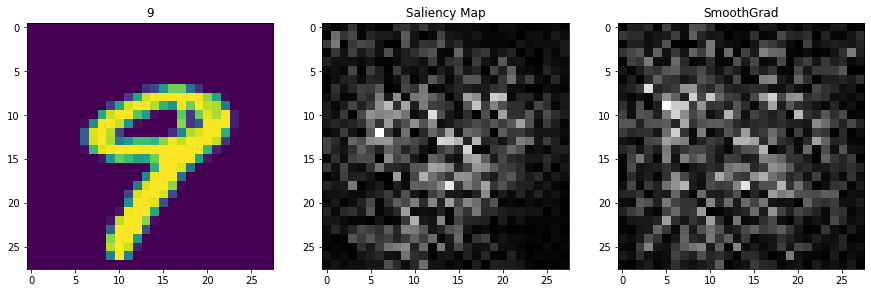

In [15]:
n = 10
sigma = .01

grads_output = get_smoothgrad(idx, model, n, sigma)
sgrad = np.abs(grads_output[0].mean(axis=-1))

plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(x_test[idx])
plt.title(label_list[y_test[idx]])
plt.subplot(132)
plt.imshow(s_map, 'gray')
plt.title('Saliency Map')
plt.subplot(133)
plt.imshow(sgrad, 'gray')
plt.title('SmoothGrad')
plt.show()

# vargrad

![Screenshot from 2019-11-15 13-27-12](https://user-images.githubusercontent.com/33189954/68917001-b377db00-07ab-11ea-8cc3-21d670b1cad7.png)

In [16]:
def get_vargrad(idx, model, n=10, sigma=1):
    y_c = model.output[0, idx]
    grads = keras.backend.gradients(y_c, model.input)[0]
    saliency = keras.backend.function([model.input], [grads])
    img_input = x_test[idx][np.newaxis,...,np.newaxis]/255
    
    smoothgrad = np.zeros_like(img_input)
    result = np.zeros_like(img_input)
    for i in range(n):
        smoothgrad += saliency([img_input + np.random.normal(scale=sigma, size=img_input.shape)])[0]
    
    smoothgrad /= n
    
    for i in range(n):
        result += saliency([img_input + np.random.normal(scale=sigma, size=img_input.shape)])[0]**2 - smoothgrad**2
    
    return result / n

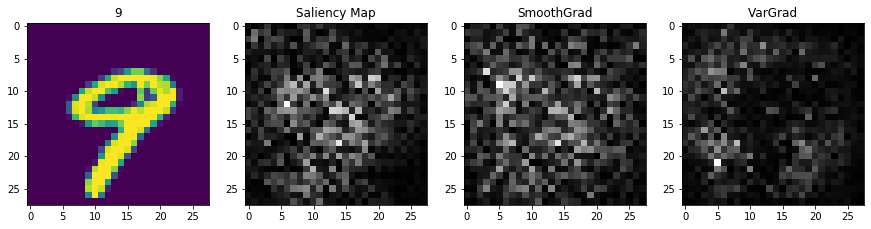

In [17]:

n = 10
sigma = .01

grads_output = get_vargrad(idx, model, n, sigma)

vgrad = np.abs(grads_output[0].mean(axis=-1))

plt.figure(figsize=(15,15))
plt.subplot(141)
plt.imshow(x_test[idx])
plt.title(label_list[y_test[idx]])
plt.subplot(142)
plt.imshow(s_map, 'gray')
plt.title('Saliency Map')
plt.subplot(143)
plt.imshow(sgrad, 'gray')
plt.title('SmoothGrad')
plt.subplot(144)
plt.imshow(vgrad, 'gray')
plt.title('VarGrad')
plt.show()

# Integrated gradients
![Screenshot from 2019-11-15 13-28-51](https://user-images.githubusercontent.com/33189954/68917039-e15d1f80-07ab-11ea-893b-237b7af6fa58.png)


In [22]:
def get_integratedgrad(idx, model,step= 50, baseline=None):
    y_c = model.output[0,idx]
    grad = keras.backend.gradients(y_c,model.input)[0]
    saliency = keras.backend.function([model.input],[grad])
    img_input = x_test[idx][np.newaxis,...,np.newaxis]/255
    
    if baseline is None:
        baseline = 0 * img_input
    assert baseline.shape == img_input.shape
    temp = np.zeros_like(img_input)

    inputs = [baseline + (float(j)/step * img_input-baseline) for j in range(step +1)]
    for inp in inputs:
        temp +=saliency([inp])[0]
    return (img_input-baseline) * temp / step

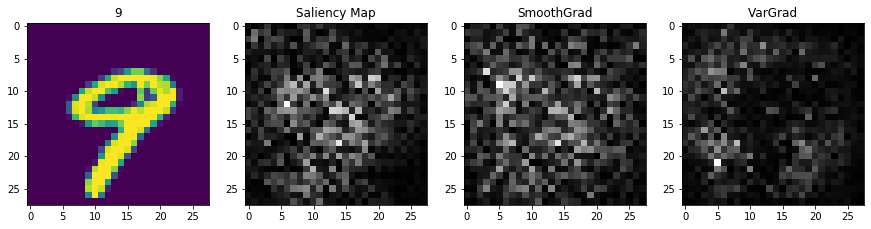

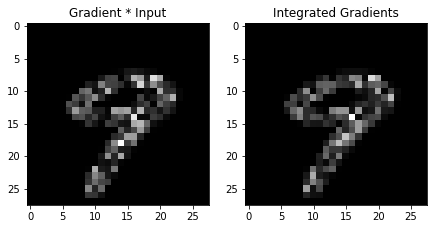

In [23]:
grads_output = get_integratedgrad(idx, model)
integratedgrad = np.abs(grads_output[0].mean(axis=-1))

plt.figure(figsize=(15,15))
plt.subplot(141)
plt.imshow(x_test[idx])
plt.title(label_list[y_test[idx]])
plt.subplot(142)
plt.imshow(s_map, 'gray')
plt.title('Saliency Map')
plt.subplot(143)
plt.imshow(sgrad, 'gray')
plt.title('SmoothGrad')
plt.subplot(144)
plt.imshow(vgrad, 'gray')
plt.title('VarGrad')
plt.show()

plt.figure(figsize=(15,15))
plt.subplot(141)
plot5 = np.abs(x_test[idx]*np.squeeze(grads_orig[0]))
plt.imshow(plot5, 'gray')
plt.title('Gradient * Input')
plt.subplot(142)
plt.imshow(integratedgrad, 'gray')
plt.title('Integrated Gradients')
plt.show()